### Stablizing sampling with small amounts of noise added when noise is low. Otherwise same as Notebook 5._CelebFaces_SGD_Init_Sampling_RmsLookahead_Finetune

In [1]:
!pip install -q diffusers datasets wandb lpips timm

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: jantic. Use `wandb login --relogin` to force relogin


True

# Set Up Dataloaders

In [16]:
#@title imports
import wandb
import torch
import torchvision
from torch import nn
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
from timm.optim.rmsprop_tf import RMSpropTF
from timm.optim.lookahead import Lookahead
from einops import rearrange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [4]:
# Perceptual loss
import lpips


In [5]:
#@title dataset from HF
from torchvision import transforms as T
from datasets import load_dataset
dataset = load_dataset('huggan/CelebA-faces')
tfm = T.Compose([T.Resize(64), T.CenterCrop(64)])
def transforms(examples):
    examples["image"] = [tfm(image.convert("RGB")) for image in examples["image"]]
    return examples
dataset = dataset.with_transform(transforms)['train']

Using custom data configuration huggan--CelebA-faces-8a807f0d7d4912ca
Found cached dataset parquet (F:/.cache/huggingface/datasets/huggan___parquet/huggan--CelebA-faces-8a807f0d7d4912ca/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

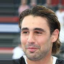

In [6]:
# Example 64px image
dataset[0]['image']

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


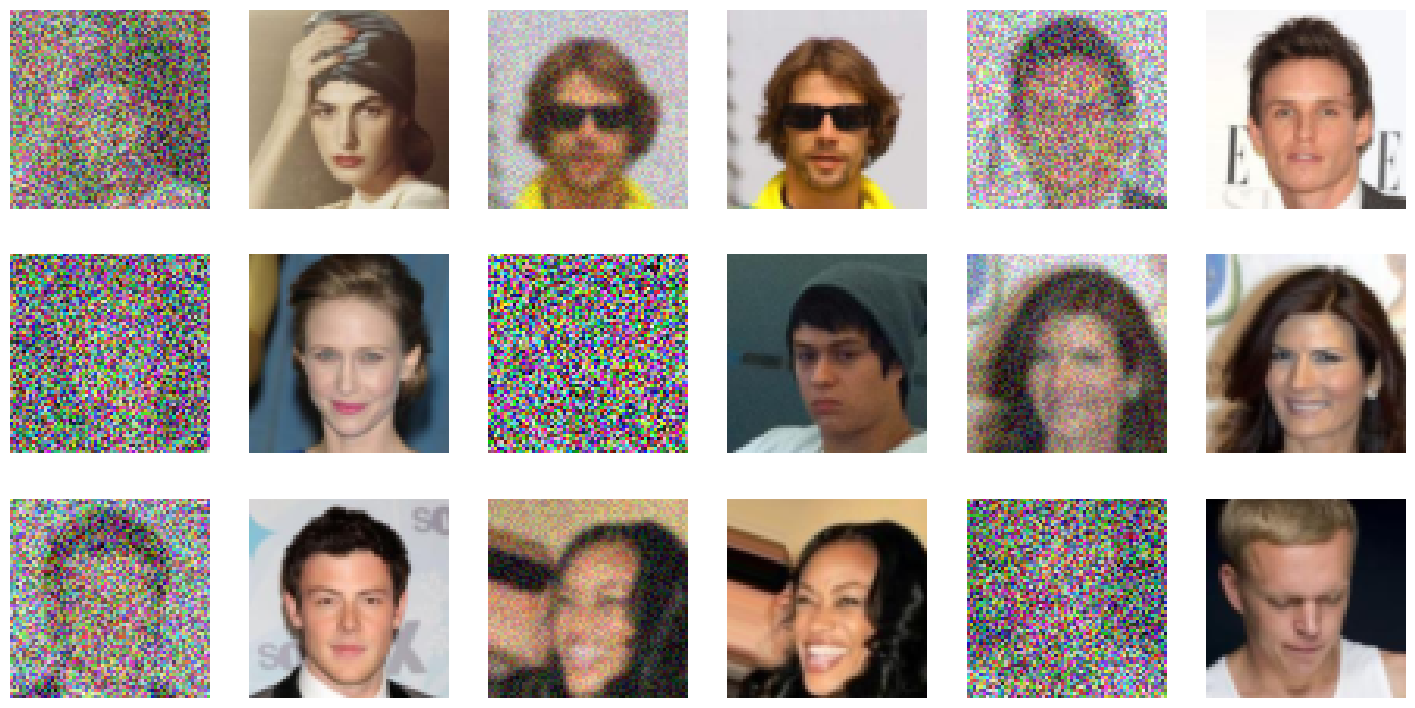

In [7]:
# Class for crappified image
class PILImageNoised(PILImage): pass
class TensorImageNoised(TensorImage):
    def show(self, ctx=None, **kwargs):
        super().show(ctx=ctx, **kwargs)
PILImageNoised._tensor_cls = TensorImageNoised

# Transform (TODO experiment)
class Crappify(Transform):
    def encodes(self, x:TensorImageNoised): 
        x = IntToFloatTensor()(x)
        blurred = T.GaussianBlur(3)(x) # Add some random blur
        noise_amount = torch.rand(x.shape[0], device=x.device)
        noise = torch.rand_like(x, device=x.device)
        noised = torch.lerp(blurred, noise, noise_amount.view(-1, 1, 1, 1)) * 255
        return noised

# Dataloader
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageNoised),ImageBlock(cls=PILImage)),
                   get_items=lambda pth: range(len(dataset)), # Gets the indexes
                   getters=[lambda idx: np.array(dataset[idx]['image'])]*2,
                   batch_tfms=[Crappify])
# dls = dblock.dataloaders('', bs=128)
dls = dblock.dataloaders('', bs=64) # Half batch size to save mem when using extra nn for perceptual loss
dls.show_batch()

# Model and training

In [8]:
#@title The unet model
from diffusers import UNet2DModel

class Unetwrapper(Module):
    def __init__(self, in_channels=3, out_channels=3, sample_size=64):
        super().__init__()
        self.net = UNet2DModel(
            sample_size=sample_size,  # the target image resolution
            in_channels=in_channels,  # the number of input channels, 3 for RGB images
            out_channels=out_channels,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(64, 64, 64, 128),  # <<< Experiment with number of layers and how many
            down_block_types=( 
                "DownBlock2D",  # a regular ResNet downsampling block
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention (uses lots of memory at higher resolutions - better to keep at lowest level or two)
            ), 
            up_block_types=(
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "AttnUpBlock2D", 
                "UpBlock2D",
                "UpBlock2D",
              ),
        )
    def forward(self, x): return self.net(x, 100).sample # Not timestep conditioning here

model = Unetwrapper().to(device)

In [106]:
def RmsLookahead(params, alpha=0.5, k=6, *args, **kwargs):
    rmsprop = RMSpropTF(params, *args, **kwargs)
    return Lookahead(rmsprop, alpha, k)

In [96]:
# Create a learner and pick LR
# learn = Learner(dls, model, loss_func=MSELossFlat())

loss_fn_alex = lpips.LPIPS(net='alex').to(device)
loss_fn_mse = MSELossFlat()

def combined_loss(preds, y):
  return loss_fn_alex.forward(preds, y).mean() + loss_fn_mse(preds, y)

opt_func = partial(OptimWrapper, opt=RmsLookahead)

learn = Learner(dls, model, loss_func=combined_loss, opt_func=opt_func)
learn.lr_find()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: C:\Users\jsa16\anaconda3\envs\course22p2\lib\site-packages\lpips\weights\v0.1\alex.pth



KeyboardInterrupt



In [ ]:
#@title Callback for logging samples (shown later in sampling section)
from PIL import Image as PILImage
class LogSamplesBasicCallback(Callback):
    def after_epoch(self):
      model = self.learn.model
      n_steps = 40
      x = torch.rand(64, 3, 64, 64).to(device)

      for i in range(n_steps):
        with torch.no_grad():
          pred = model(x)
        mix_factor = 1/(n_steps - i)
        x = x*(1-mix_factor) + pred*mix_factor

      im = torchvision.utils.make_grid(x.detach().cpu(), nrow=8).permute(1, 2, 0).clip(0, 1) * 255
      im = PILImage.fromarray(np.array(im).astype(np.uint8))
      wandb.log({'Sample generations basic':wandb.Image(im)})

    def after_step(self):
      if self.train_iter%100 == 0: # Also log every 100 training steps
        model = self.learn.model
        n_steps = 40
        x = torch.rand(64, 3, 64, 64).to(device)

        for i in range(n_steps):
          with torch.no_grad():
            pred = model(x)
          mix_factor = 1/(n_steps - i)
          x = x*(1-mix_factor) + pred*mix_factor

        im = torchvision.utils.make_grid(x.detach().cpu(), nrow=8).permute(1, 2, 0).clip(0, 1) * 255
        im = PILImage.fromarray(np.array(im).astype(np.uint8))
        wandb.log({'Sample generations basic':wandb.Image(im)})

In [ ]:
# Train a bit
cfg = dict(model.net.config)
cfg['num_epochs'] = 10
cfg['lr_max'] = 1e-4
cfg['comments'] = 'Using alex-based lpips loss, RmsPropLookahead instead of Adam'
cfg['dataset'] = 'faces'
wandb.init(project='fastdiffusion', job_type='quick train', config=cfg)
learn.fit_one_cycle(cfg['num_epochs'], lr_max=cfg['lr_max'], cbs=[WandbCallback(n_preds=8), LogSamplesBasicCallback()])
wandb.finish()

In [ ]:
learn.show_results()

In [ ]:
torch.save(learn.model.state_dict(), 'faces_10e_model.pt')

# Sampling

In [11]:
learn.model.load_state_dict(torch.load('./faces_10e_model.pt'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


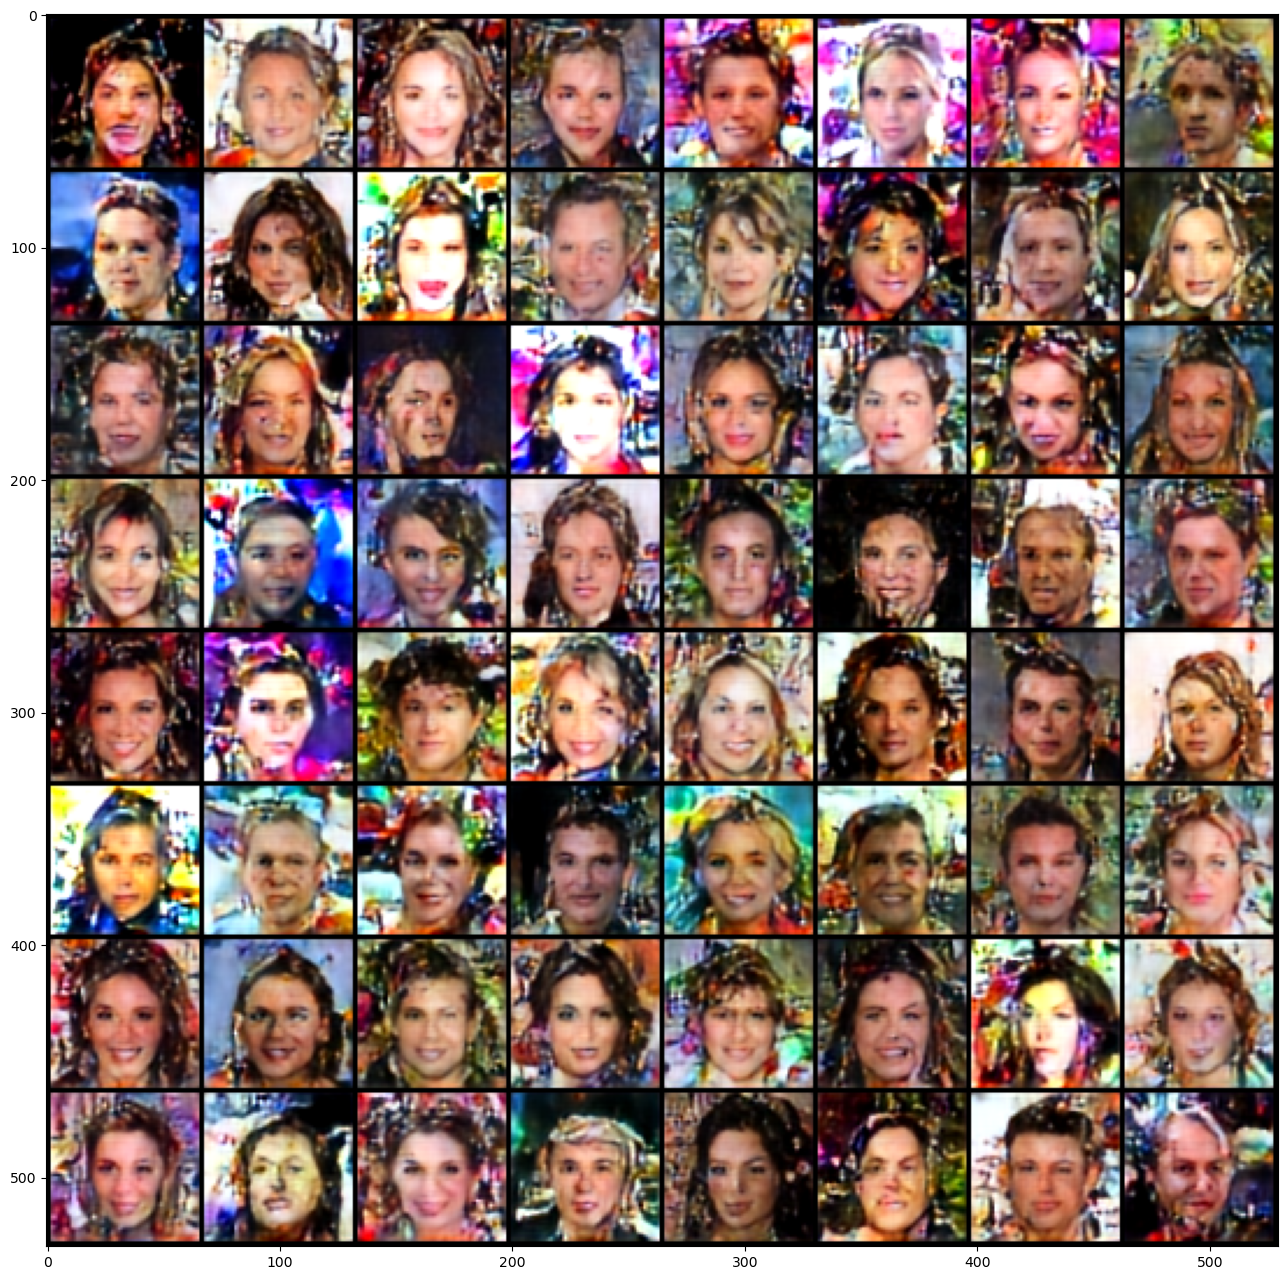

In [16]:
#@title sample with naive method from first test
n_steps = 40 # Set steps to 1 to see raw preds on first input
x = torch.rand(64, 3, 64, 64).to(device) # Raw noise starting point

for i in range(n_steps):
    with torch.no_grad():
        pred = model(x)
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8).permute(1, 2, 0))

# 2 Step SGD Init, 40 Step RmsLookahead Finetune

0 tensor(0.0665, device='cuda:0') tensor(0.1045, device='cuda:0') tensor(0.1045, device='cuda:0') 5e-07


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Stopping at: 9
0 tensor(0.0022, device='cuda:0') tensor(0.0003, device='cuda:0') tensor(0.0003, device='cuda:0') 5e-07
10 tensor(0.0021, device='cuda:0') tensor(0.0003, device='cuda:0') tensor(0.0003, device='cuda:0') 0.02500025
20 tensor(0.0019, device='cuda:0') tensor(0.0002, device='cuda:0') tensor(0.0002, device='cuda:0') 0.05
30 tensor(0.0014, device='cuda:0') tensor(0.0003, device='cuda:0') tensor(0.0003, device='cuda:0') 0.02500025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(5.8848e-07, device='cuda:0')
Stopping at: 39


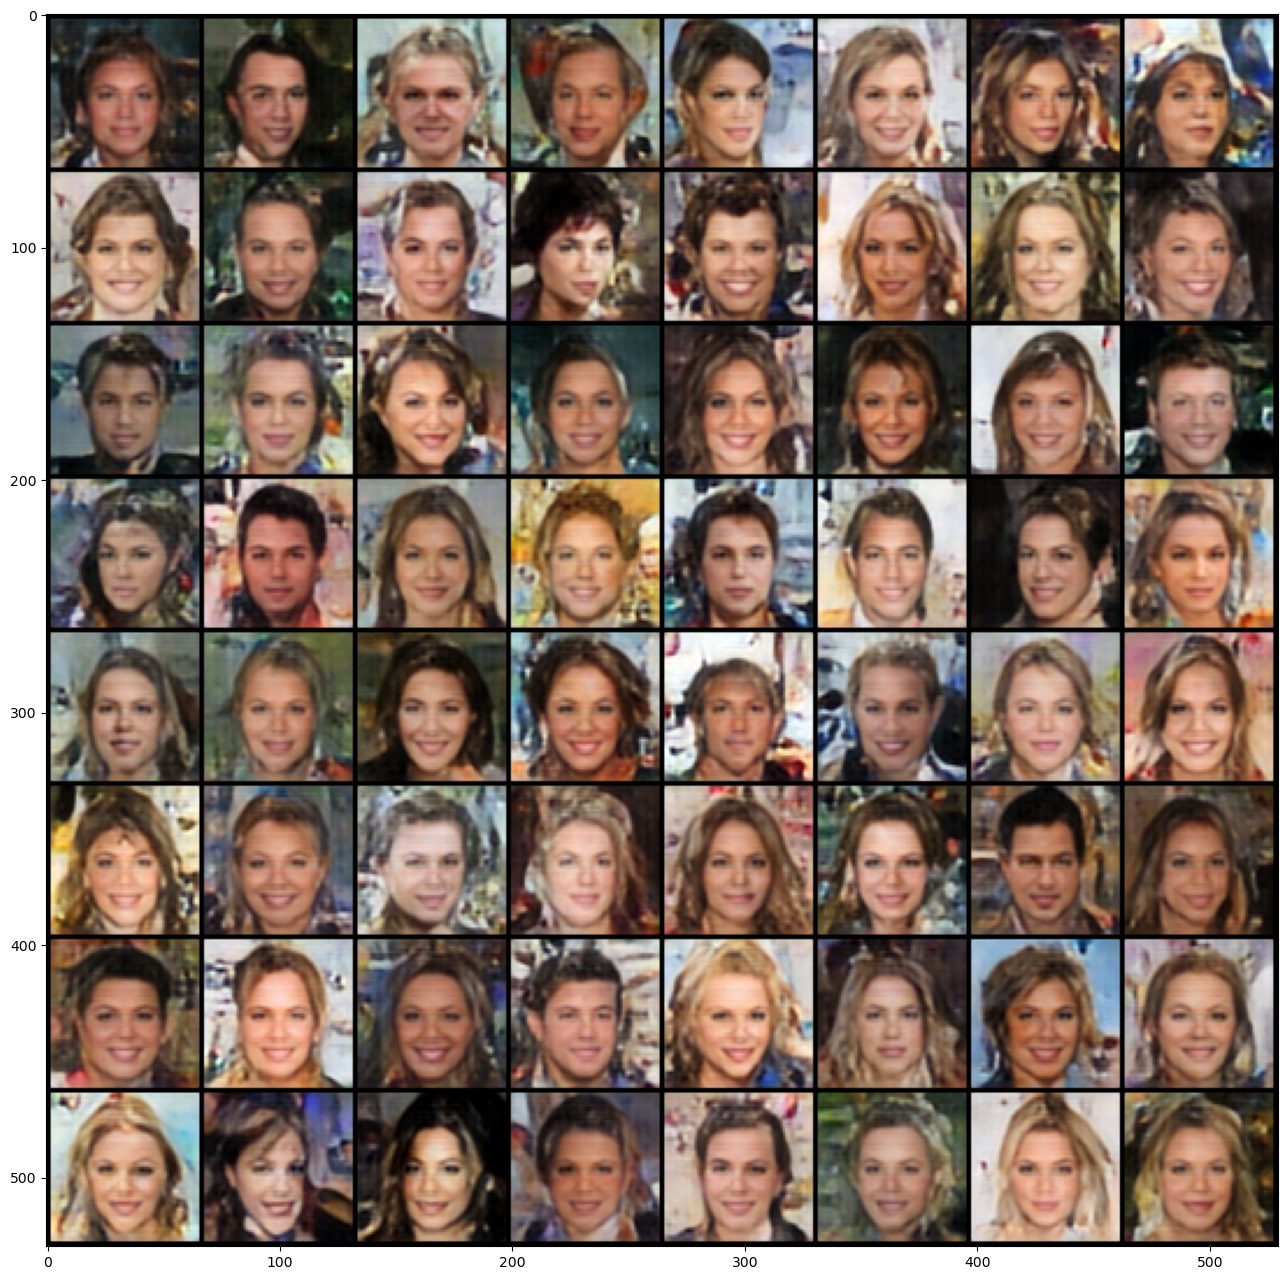

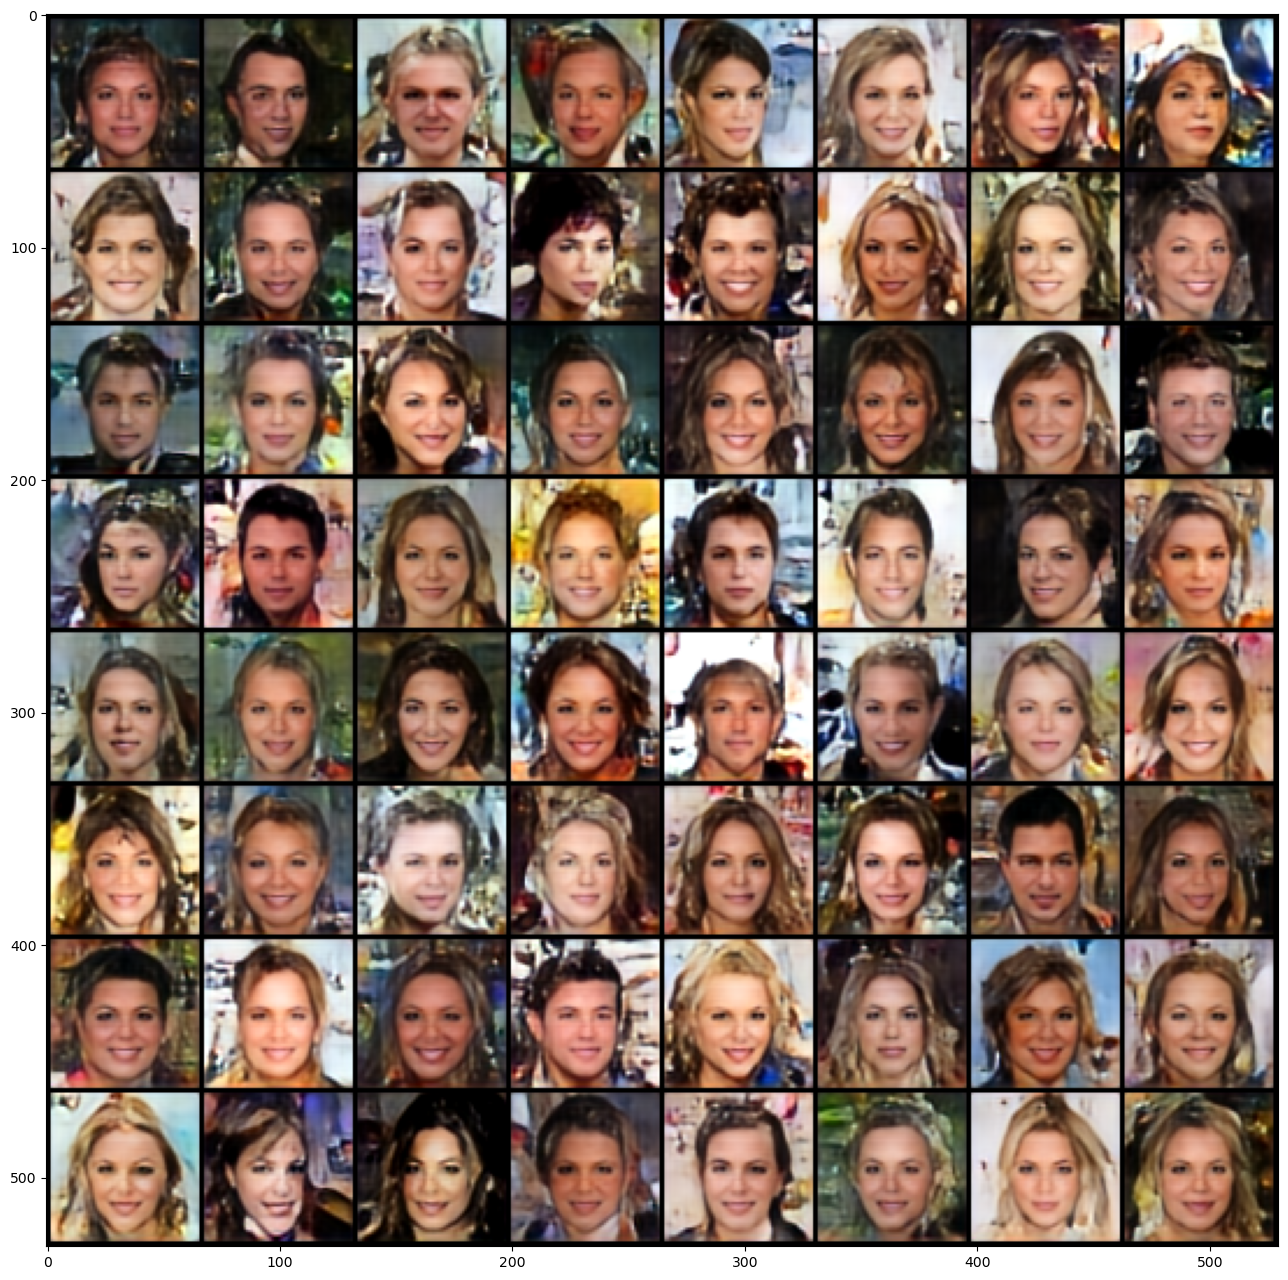

In [142]:
#@title sample with an optimiser
torch.random.manual_seed(1000)
x = torch.rand(64, 3, 64, 64).to(device)
x.requires_grad = True

n_steps=10
lr_max=5e-2
div=100000.
div_final=1e5
pct_start=0.5

lr_sched_fn = combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final)
optim = OptimWrapper(opt=torch.optim.SGD([x], lr=lr_max, momentum=0.01))
#optim = OptimWrapper(opt=RmsLookahead([x], lr=lr_max))
prev_noise_var = 1e6

for i in range(n_steps):
    pos = i/(n_steps)
    lr = lr_sched_fn(pos)
    
    optim.set_hyper('lr', lr)
    
    with torch.no_grad():
        net_output = model(x)
        flip_output = TF.hflip(model(TF.hflip(x)))
        denoised_output = (net_output + flip_output)/2.0
        noise_pred = x - denoised_output
        net_output = denoised_output
        
    # # Early stopping
    if (noise_pred.float()).var() < 0.0025 or i == n_steps-1:
        x = net_output
        print('Stopping at:', i)
        break

    # noise_pred is basically the grad, so GD on this should find a minimum!
    x.grad = noise_pred.float()
    prev_noise_var = noise_pred.float().var()
    
    if i%10==0:
        print(i, x.grad.mean(), x.grad.var(), noise_pred.float().var(), lr) # Useful to watch the noise variance
    #torch.nn.utils.clip_grad_norm_(x, 250.0)
    optim.step()
    optim.zero_grad() # Not really needed since we're setting .grad ourselves but anyway...
    
n_steps=40 
lr_max=5e-2
div=100000.
div_final=1e5
pct_start=0.25    
    
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8).permute(1, 2, 0))    

optim = OptimWrapper(opt=RmsLookahead([x], lr=lr_max))


for i in range(n_steps):
    pos = i/(n_steps)
    lr = lr_sched_fn(pos)
    #lr = lr_max
    
    optim.set_hyper('lr', lr)
    
    with torch.no_grad():
        net_output = model(x)
        flip_output = TF.hflip(model(TF.hflip(x)))
        denoised_output = (net_output + flip_output)/2.0
        noise_pred = x - denoised_output
        
    # noise_pred is basically the grad, so GD on this should find a minimum!
    x.grad = noise_pred.float()
    grad_mean = x.grad.mean()
    var_diff = (noise_pred.float().var() - prev_noise_var).abs()
    
    # # Early stopping
    if i == n_steps-1 or (i > 0 and grad_mean < 0 and var_diff < 1e-5):
        x = net_output
        print(var_diff)
        print('Stopping at:', i)
        break
        
    prev_noise_var = noise_pred.float().var() 
    
    if i%10==0:
        print(i, x.grad.mean(), x.grad.var(), noise_pred.float().var(), lr) # Useful to watch the noise variance
    #torch.nn.utils.clip_grad_norm_(x, 250.0)
    optim.step()
    optim.zero_grad() # Not really needed since we're setting .grad ourselves but anyway...
    
    if grad_mean < 0.0:
        print(grad_mean)
        x = x + torch.randn_like(x)*0.0025

    
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8).permute(1, 2, 0))